In [105]:
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import spaces
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch 
import glob
import os
import time 

# 1. Data Preparation

We have few trajectories of fruit flies and we will be loadiung them and preparing in a formate that can be used for training the model. We concatenate all trajectories get first 90% of the data as training data and last 10% as validation data.

In [106]:
all_files = glob.glob(os.path.join('..','Data','processed', '*.csv'))
trajectories = []
for filename in all_files:
    trajectories.append(pd.read_csv(os.path.join(filename)))

In [107]:
# Prepare next coordinates and done in dataframe
for trajectory in trajectories:
    # Assigning subsequent coordinates
    trajectory['next_x'] = trajectory['x'].shift(-1)
    trajectory['next_y'] = trajectory['y'].shift(-1)

    trajectory['done'] = False
    # Mark the last row's 'done' as True
    trajectory.at[trajectory.index[-1], 'done'] = True

In [109]:
temp_df

,x,y,light,speed,curvature,near_boundary,state,next_x,next_y,done
0,317540.0,299140.0,0,NaN,0.000000,False,unclassified,317560.0,299100.0,False
1,317560.0,299100.0,0,44.721360,0.316228,False,walk,317580.0,299080.0,False
2,317580.0,299080.0,0,28.284271,-0.447214,False,walk,317590.0,299050.0,False
3,317590.0,299050.0,0,31.622777,0.263117,False,walk,317610.0,299020.0,False
4,317610.0,299020.0,0,36.055513,-0.124035,False,walk,317620.0,299000.0,False
...,...,...,...,...,...,...,...,...,...,...
1758267,119260.0,92501.0,0,9.000000,0.857493,False,walk,119240.0,92513.0,False
1758268,119240.0,92513.0,0,23.323808,-0.857493,False,walk,119240.0,92527.0,False
1758269,119240.0,92527.0,0,14.000000,0.398726,False,walk,119230.0,92550.0,False
1758270,119230.0,92550.0,0,25.079872,0.034285,False,walk,119220.0,92571.0,False


### Action Analysis
-----
Objective: Identify specific actions performed by the fly, such as grooming, flying, or social interactions. We will use a predefined set of actions and classify each segment of the trajectory based on these actions.
- Stop: The fly is stationary.
- left turn: The fly makes a sharp left turn.
- right turn: The fly makes a sharp right turn.
- up: The fly moves up.
- down: The fly moves down.
- up left: The fly moves diagonally up and left.
- up right: The fly moves diagonally up and right.
- down left: The fly moves diagonally down and left.
- down right: The fly moves diagonally down and right.


#### Method 1: Using tan agle to calculate the curvature of the trajectory. Segment the trajectory based on the differenet threshold of theta. 
![Screenshot 2024-03-25 at 10.21.00 AM.png](<attachment:Screenshot 2024-03-25 at 10.21.00 AM.png>)
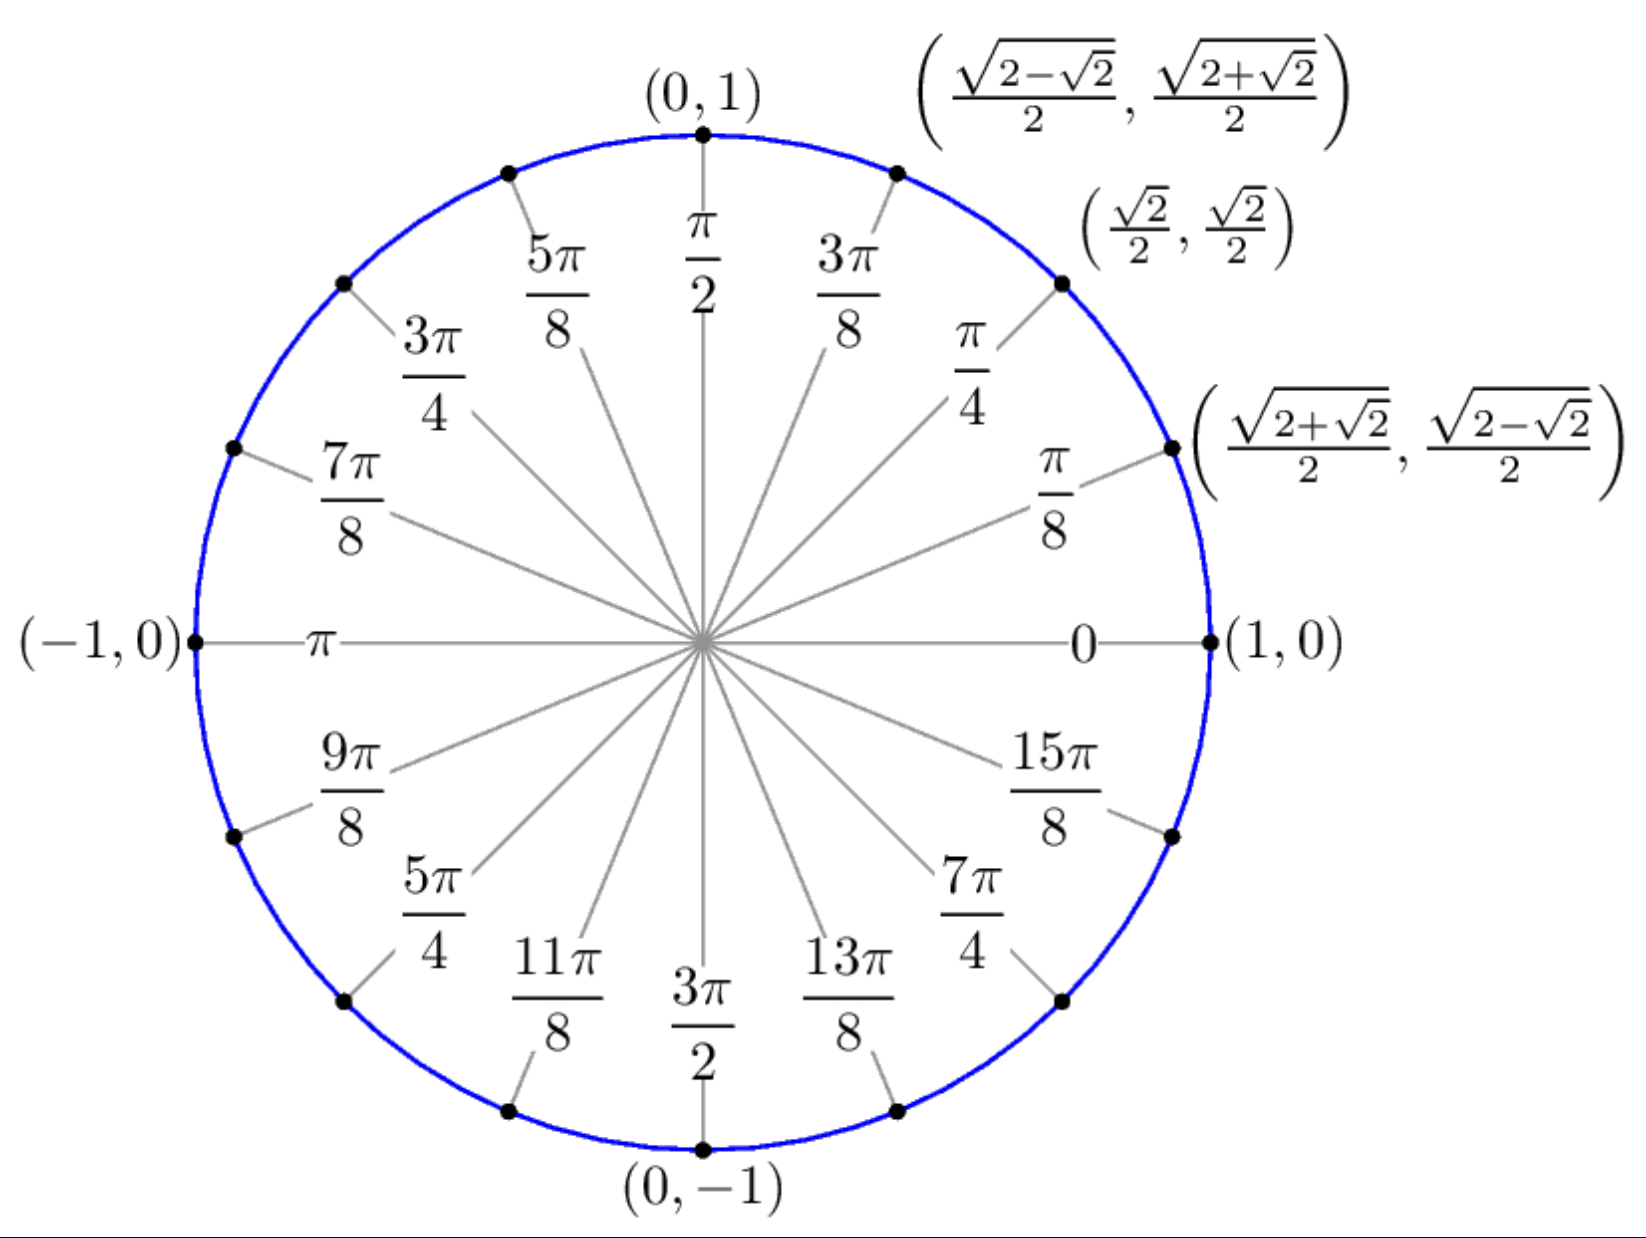

In [110]:
# improve the colums according to newly defined actions
def compute_action_v1(df):
    """Computes direction based on changes in x and y."""
    df['dx'] = - df['x'].diff(-1)
    df['dy'] = - df['y'].diff(-1)

    # Normalize to get only the direction
    directions = np.arctan2(df['dy'], df['dx'])
    
    # Categorize directions into actions
    # Note: Adjust thresholds as needed to distinguish between curved and sharp turns
    conditions = [
        (df['dx'] == 0) & (df['dy'] == 0),  # Stop
        (directions.between(-np.pi/8, np.pi/8, inclusive='both')),  # Right
        (directions.between(np.pi/8, 3*np.pi/8, inclusive='both')),  # Up-Right
        (directions.between(3*np.pi/8, 5*np.pi/8, inclusive='both')),  # Up
        (directions.between(5*np.pi/8, 7*np.pi/8, inclusive='both')),  # Up-Left
        (directions.between(-7*np.pi/8, -5*np.pi/8, inclusive='both')),  # Down-Left
        (directions.between(-5*np.pi/8, -3*np.pi/8, inclusive='both')),  # Down
        (directions.between(-3*np.pi/8, -np.pi/8, inclusive='both')),  # Down-Right
         # Handle 'left' by combining angles close to -π and π
        ((directions > 7*np.pi/8) | (directions < -7*np.pi/8)),  # Left
    ]
    choices =  ['stop', 'right', 'up_right', 'up', 'up_left', 'bottom_left', 'down', 'bottom_right', 'left']
    df['action_theta'] = np.select(conditions, choices, default='stop')
    return df


In [84]:
for trajectory in trajectories:
    compute_action_v1(trajectory)

#### Method 2: Using the coordinates of the fly to segment the trajectory. we will simply calculate the distance between the points and if the distance is greater than a threshold we will consider it as a new segment.

In [111]:
def compute_action_v2(df):
    # Calculate differences in x and y
    df['dx'] = - df['x'].diff(-1)
    df['dy'] = - df['y'].diff(-1)
    
    # Define movement directions based on dx and dy
    conditions = [
        (df['dx'] == 0) & (df['dy'] == 0),
        (df['dx'] == 0) & (df['dy'] > 0),
        (df['dx'] == 0) & (df['dy'] < 0),
        (df['dx'] < 0) & (df['dy'] == 0),
        (df['dx'] > 0) & (df['dy'] == 0),
        (df['dx'] > 0) & (df['dy'] > 0),
        (df['dx'] < 0) & (df['dy'] > 0),
        (df['dx'] > 0) & (df['dy'] < 0),
        (df['dx'] < 0) & (df['dy'] < 0)
    ]
    actions = ['stop', 'up', 'down', 'left', 'right', 'up_right', 'up_left', 'bottom_right', 'bottom_left']
    df['action_coordinates'] = np.select(conditions, actions, default='stop')  # Default to 'stop' if none of the conditions match
    
    return df

In [86]:
for trajectory in trajectories:
    compute_action_v2(trajectory)

In [87]:
trajectory.head(20)

,x,y,light,speed,curvature,near_boundary,state,next_x,next_y,done,dx,dy,action_theta,action_coordinates
0,177870.0,73922.0,0,NaN,0.000000,False,unclassified,177870.0,73922.0,False,-0.0,-0.0,stop,stop
1,177870.0,73922.0,0,0.000000,NaN,False,stop,177880.0,73922.0,False,10.0,-0.0,right,right
2,177880.0,73922.0,0,10.000000,NaN,False,unclassified,177880.0,73922.0,False,-0.0,-0.0,stop,stop
3,177880.0,73922.0,0,0.000000,NaN,False,stop,177890.0,73922.0,False,10.0,-0.0,right,right
4,177890.0,73922.0,0,10.000000,-0.099504,False,walk,177900.0,73921.0,False,10.0,-1.0,right,bottom_right
5,177900.0,73921.0,0,10.049876,NaN,False,unclassified,177900.0,73921.0,False,-0.0,-0.0,stop,stop
6,177900.0,73921.0,0,0.000000,NaN,False,stop,177910.0,73921.0,False,10.0,-0.0,right,right
7,177910.0,73921.0,0,10.000000,0.000000,False,walk,177930.0,73921.0,False,20.0,-0.0,right,right
8,177930.0,73921.0,0,20.000000,NaN,False,unclassified,177930.0,73921.0,False,-0.0,-0.0,stop,stop
9,177930.0,73921.0,0,0.000000,NaN,False,stop,177940.0,73921.0,False,10.0,-0.0,right,right


In [88]:
# merge trajectories 
df = pd.concat(trajectories, ignore_index=True)

In [89]:
df.to_csv(os.path.join('..','Data','processed','combined_trajectories.csv'), index=False)

## 2. Define Environment

First, we need to define the environment, which includes the state space, action space, and the mechanism to transition from one state to another given an action. The environment also needs to provide a reward signal based on the current state or the transition just made.

In [45]:
class FlyEnvironment(gym.Env):
    def __init__(self, grid_size, source_location, detection_radius):
        """
        Initializes the environment.
        
        grid_size: Size of the squared grid.
        source_location: Tuple (x, y) indicating the source location.
        detection_radius: Radius in which the light condition turns on, indicating proximity to the source.
        """
        self.x_min, self.x_max, self.y_min, self.y_max = grid_size[0], grid_size[1], grid_size[2], grid_size[3]
        self.source_location = source_location
        self.detection_radius = detection_radius
        self.state = self.reset()  # To be initialized as (x, y, light_condition)
        self.max_magnitude = 1000
        self.action_effects = {
            0: (0, 0),
            1: (0, 10),
            2: (0, -10),
            3: (-10, 0),
            4: (10, 0),
            5: (10, 10),
            6: (-10, 10),
            7: (10, -10), # use left sharp turn formula 
            8: (-10, -10), # use left sharp turn formula
        }
        self.action_space = ['stop', 'up', 'down', 'left', 'right', 'up_right', 'up_left', 'bottom_right', 'bottom_left']

        # Define angle ranges for each action (in radians)
        self.action_angle_ranges = {
            0: (0, 0),
            1: (3*np.pi/8, 5*np.pi/8),
            2: (-5*np.pi/8, -3*np.pi/8),
            3: ((7*np.pi/8, np.pi), (-np.pi, -7*np.pi/8)),  # Special case for 'left'
            4: (-np.pi/8, np.pi/8),
            5: (np.pi/8, 3*np.pi/8),
            6: (5*np.pi/8, 7*np.pi/8),
            7: (-3*np.pi/8, -np.pi/8),
            8: (-7*np.pi/8, -5*np.pi/8),
        }

    def reset(self):
        """
        Resets the environment to an initial state.
        """
        x = np.random.randint(low = self.x_min, high = self.x_max)
        y = np.random.randint(low = self.y_min, high = self.y_max)
        light_condition = 0
        self.state = (x, y, light_condition)
        return self.state

    def is_near_to_source(self, position):
        """
        Determines if the given position is within the detection radius of the source.
        """
        distance_to_source = np.linalg.norm(np.array(position) - np.array(self.source_location))
        if distance_to_source < self.detection_radius:
            return 1
        else:
            return 0
    
    def step(self, action):
        """
        Executes the given action and returns the new state, reward, and done flag.

        """
        x, y, light_condition = self.state

        # Adjust for 'left' action which spans across -π to π
        if action == 3:  # Assuming 'left' corresponds to action index 3
            # Handle 'left' by randomly choosing an angle from one of its two ranges
            if np.random.rand() > 0.5:
                angle_range = (7*np.pi/8, np.pi)
            else:
                angle_range = (-np.pi, -7*np.pi/8)
        else:
            angle_range = self.action_angle_ranges[action]

        angle_min, angle_max = angle_range

        if action != 0:
            # Select a random angle within the action's range
            angle = np.random.uniform(angle_min, angle_max)

            # Select a random magnitude within the defined range
            magnitude = np.random.uniform(1, self.max_magnitude)

            # Calculate dx and dy based on the angle and magnitude
            dx = magnitude * np.cos(angle)
            dy = magnitude * np.sin(angle)
        else:
            dx, dy = 0, 0

        # Update position with boundaries consideration
        # dx, dy = self.action_effects[action]
        new_x = np.clip(x + dx, self.x_min, self.x_max - 1).astype(int)
        new_y = np.clip(y + dy, self.y_min, self.y_max - 1).astype(int)
        new_light_condition = self.is_near_to_source((new_x, new_y))
        self.state = (new_x, new_y, new_light_condition)

        reward = self.get_reward(new_x, new_y, new_light_condition)
        done = self.is_done(new_x, new_y)
        return self.state, reward, done, {}

    def get_reward(self, x, y, light_condition):
        """
        Defines the reward function based on the current state.
        """
        # Reward conditions based on proximity to source and light condition
        if light_condition:
            distance_to_source = np.linalg.norm(np.array((x, y)) - np.array(self.source_location))
            return self.detection_radius - distance_to_source  # Closer to source => higher reward
        return -1  # Encourage moving towards the light

    def is_done(self, x, y):
        """
        Determines if the episode is done.
        """
        return (x, y) == self.source_location

    def render(self):
        """
        Renders the current state of the environment.
        """
        fig,ax = plt.subplots(figsize=(15, 15))
        ax.set_xlim(self.x_min, self.x_max)
        ax.set_ylim(self.y_min, self.y_max)
        ax.plot(self.source_location[0], self.source_location[1], 'r*', markersize=15, label='Source')
        ax.plot(self.state[0], self.state[1], 'b^', markersize=10, label='Fly')
        detection_circle = plt.Circle(self.source_location, self.detection_radius, color='r', fill=False, linestyle='--', label='Detection Boundary')

        # arena_circle = plt.Circle(self.source_location, 80000, color='black', fill=False, linestyle='-', label='Arena Boundary')

        ax.add_artist(detection_circle)
        # ax.add_artist(arena_circle)
        ax.grid(which='both')
        plt.legend()
        plt.show()

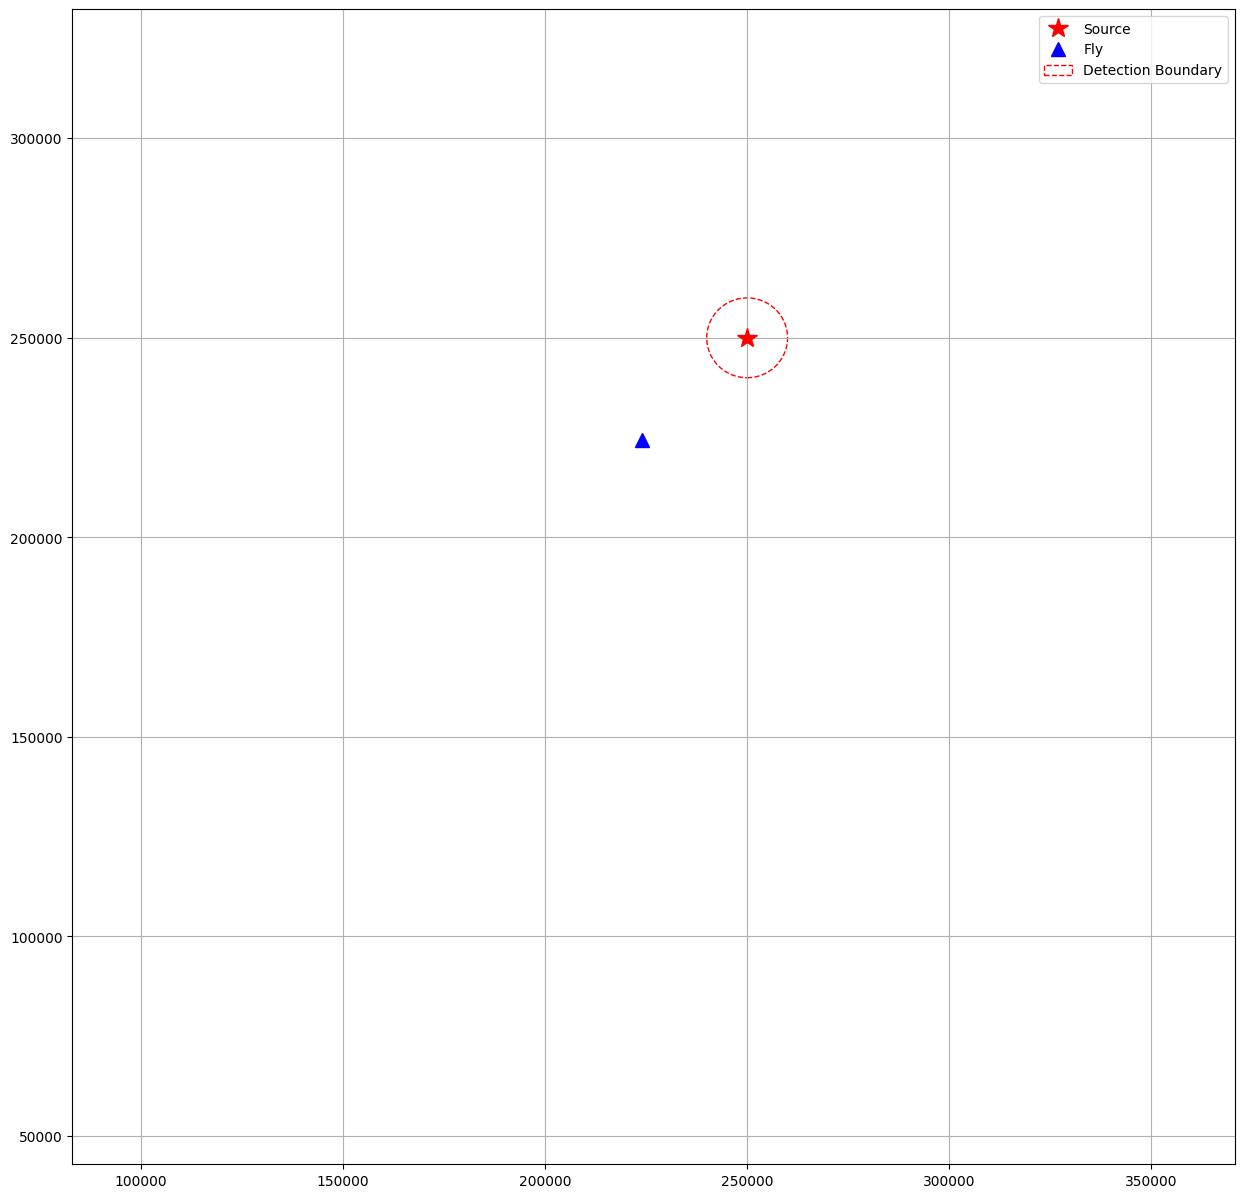

In [46]:
# Initializing and using the environment
env = FlyEnvironment(grid_size = (df.x.min(), df.x.max(), df.y.min(), df.y.max()), source_location=(250000,250000), detection_radius=10000)
curent_state = env.reset()
env.render()

# Step 2: Define the RL Agent
The RL agent will interact with the environment by selecting actions based on its policy, receiving feedback in the form of rewards, and learning to improve its policy over time.

### 2.2 we will try DQN algorithm to solve the environment


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(state_size, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, 64)
        self.linear4 = nn.Linear(64, 32)
        self.output = nn.Linear(32, action_size)
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.relu(self.linear4(x))
        return self.output(x)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=200000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            act_values = self.model(state)
        return np.argmax(act_values.cpu().data.numpy())

    def train(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            reward = torch.FloatTensor([reward])
            done = torch.BoolTensor([done])
            
            target = reward if done else (reward + self.gamma * torch.max(self.model(next_state).detach()))
            current_q_values = self.model(state)

            # We only want to update the Q-value for the action taken
            expected_q_values = current_q_values.clone().detach()
            expected_q_values[0][action] = target
            
            self.optimizer.zero_grad()
            loss = nn.functional.mse_loss(current_q_values, expected_q_values)
            loss.backward()
            self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [48]:
agent = DQNAgent(state_size=len(env.state), action_size=len(env.action_space))

In [15]:
# state = env.reset()
# state = np.reshape(state, [len(env.state)])

# action = agent.act(state)
# print(f"Selected action: {action}")

# next_state, reward, done, _ = env.step(action)
# agent.remember(state, action, reward, next_state, done)
# print("Experience remembered")

In [49]:
## Fill memory with random experiences
# for _ in range(10000):  # Assuming the batch size is 32, fill with double that amount
#     state = env.reset()
#     state = np.reshape(state, [len(env.state)])
#     action = agent.act(state)
#     next_state, reward, done, _ = env.step(action)
#     next_state = np.reshape(next_state, [len(env.state)])
#     agent.remember(state, action, reward, next_state, done)

# # Train the agent
# agent.train(32)
# print("Agent trained on a minibatch")


Agent trained on a minibatch


## Step 3: Training the Agent

After setting up your DQNAgent with a train method, the next step is to run the training loop where your agent interacts with the environment, collects experiences, and learns from them. This involves repeatedly executing actions in the environment, storing the results in memory, and periodically training the agent on a batch of experiences from memory.

Training involves running episodes where the agent explores the environment, takes actions, receives feedback, and learns from it. 

In [15]:
def infer_action(current_state, next_state):
    dx = next_state[0] - current_state[0]
    dy = next_state[1] - current_state[1]
    
    if dx == 0 and dy == 0:
        return 0, 'stop'
    elif dx == 0 and dy > 0:
        return 1, 'up'
    elif dx == 0 and dy < 0:
        return 2, 'down'
    elif dx < 0 and dy == 0:
        return 3, 'left'
    elif dx > 0 and dy == 0:
        return 4, 'right'
    elif dx > 0 and dy > 0:
        return 5, 'up_right'
    elif dx < 0 and dy > 0:
        return 6, 'up_left'
    elif dx > 0 and dy < 0:
        return 7, 'bottom_right'  # or 'down_right'
    elif dx < 0 and dy < 0:
        return 8, 'bottom_left'  # or 'down_left'
    else:
        return None  # In case of unexpected condition


### Storing Experiences in agent's memory 

In [77]:

from tqdm.auto import tqdm, trange

1735521

In [ ]:
# we need to iterate over each preloaded trajectory, process it to extract states, actions, rewards, and next states, then store these in the agent's memory. After populating the memory with one or more trajectories, you can proceed with the usual training steps, periodically sampling from the memory to update the agent's model.

for trajectory in tqdm(trajectories, desc="Processing trajectories", total=len(trajectories),leave=False):
    time.sleep(5)
    for i in tqdm(range(len(trajectory)), desc="Adding Observation", total=len(trajectory),leave=False):
        state = trajectory.iloc[i][['x', 'y', 'light']].values
        next_state = trajectory.iloc[i+1][['x', 'y', 'light']].values

        # Assuming you have a way to determine the action and reward from your data
        #action, _ = infer_action(current_state=trajectory.iloc[i][['x', 'y']].tolist(),next_state=trajectory.iloc[i+1][['x', 'y']].tolist()) # Determine the action taken to get from state to next_state
        action = env.action_space.index(trajectory.iloc[i]['action_theta']) #trajectory.iloc[i]['action_coordinates']

        reward = -1 if trajectory.iloc[i]['light'] == 0 else 1 # Determine the reward received for the transition
        done = trajectory.iloc[i]['done'] # done = (i == len(trajectory) - 2)  # Mark done on the last transition

        # Reshape for compatibility with your DQN model input
        state = np.reshape(state, [agent.state_size])
        next_state = np.reshape(next_state, [agent.state_size])
        
        agent.remember(state, action, reward, next_state, done)

In [29]:

# Define hyperparameters
num_episodes = 2  # Number of episodes to run the agent for
batch_size = 32  # Batch size for training

# Initialize environment and agent
env = FlyEnvironment(grid_size = (df.x.min(), df.x.max(), df.y.min(), df.y.max()), source_location=(250000,250000), detection_radius=15000)
env.reset()
# Create your environment here
state_size = len(env.state)  # Define state size based on your environment
action_size = len(env.action_space)  # Define action size based on your environment
agent = DQNAgent(state_size, action_size)

# Run training loop
for episode in range(num_episodes):
    state = env.reset()  # Reset environment for new episode
    state = np.reshape(state, [1, state_size])  # Reshape state for the model
    
    total_reward = 0  # Track total reward per episode
    done = False
    while not done:
        action = agent.act(state)  # Select action based on the current state
        next_state, reward, done, _ = env.step(action)  # Execute action in the environment
        next_state = np.reshape(next_state, [state_size])  # Reshape next_state
        
        agent.remember(state, action, reward, next_state, done)  # Store experience in memory
        state = next_state  # Update state to next state
        total_reward += reward
        
        if len(agent.memory) > batch_size:
            agent.train(batch_size)  # Train the agent by replaying experiences
    
    # Log results and perform any episode end actions
    print(f"Episode: {episode+1}/{num_episodes}, Total Reward: {total_reward}")
    
    # Optionally reduce epsilon after each episode to reduce exploration over time
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay


## Step 4: Evaluation and Policy Improvement
After training, it's important to evaluate the agent's performance and refine its policy as needed. This can be done by running the agent in the environment without exploration (i.e., always choosing the best action according to the Q-table) and observing its behavior.

In [ ]:
def evaluate(agent, environment, episodes=100):
    total_rewards = 0
    for _ in range(episodes):
        state = environment.reset()
        done = False
        while not done:
            # Choose the best action based on learned Q-values
            action = agent.get_best_action(state)
            next_state, reward, done, _ = environment.step(action)
            state = next_state
            total_rewards += reward
    average_reward = total_rewards / episodes
    print(f"Average Reward after {episodes} episodes: {average_reward}")


# Evaluate the trained agent
evaluate(agent, env)

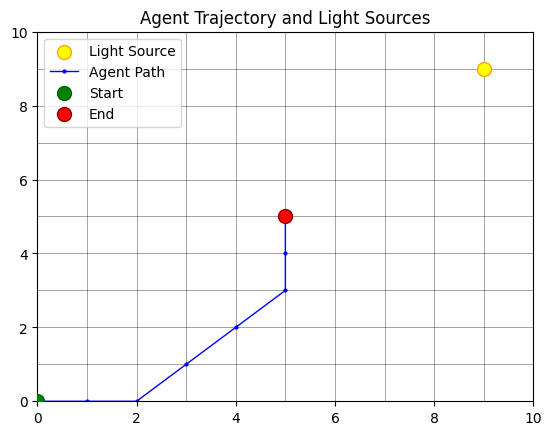

In [8]:
import matplotlib.pyplot as plt
import numpy as np

class FlyEnvironment:
    def __init__(self, grid_size, light_positions):
        self.grid_size = grid_size
        self.light_positions = light_positions
        self.state = (0, 0)  #Starting position
        self.done = False
    
    def reset(self):
        self.state = (0, 0)  # Reset to starting position
        self.done = False
        return self.state
    
    def step(self, action):
        x, y = self.state
        if action == 0:  # move up
            y = min(y + 1, self.grid_size - 1)
        elif action == 1:  # move down
            y = max(y - 1, 0)
        elif action == 2:  # move right
            x = min(x + 1, self.grid_size - 1)
        elif action == 3:  # move left
            x = max(x - 1, 0)
        
        self.state = (x, y)
        
        # Check if the new state is a light position
        if self.state in self.light_positions:
            reward = 1  # Found light source
            self.done = True
        else:
            reward = -0.1  # Not at light source
        
        return self.state, reward, self.done

    def render(self, trajectory):
        """
        Plot the trajectory of the agent in the environment along with light positions.
        """
        fig, ax = plt.subplots()
        # Grid and light positions
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        grid_x, grid_y = np.meshgrid(range(self.grid_size + 1), range(self.grid_size + 1))
        ax.plot(grid_x, grid_y, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
        ax.plot(grid_y, grid_x, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
        
        # Plot light positions
        for light_pos in self.light_positions:
            ax.scatter(*light_pos, color='yellow', s=100, label='Light Source', edgecolors='orange', zorder=5)
        
        # Plot trajectory
        trajectory = np.array(trajectory)
        ax.plot(trajectory[:, 0], trajectory[:, 1], color='blue', marker='o', linestyle='-', linewidth=1, markersize=2, label='Agent Path')
        
        # Starting position
        ax.scatter(*trajectory[0], color='green', s=100, label='Start', edgecolors='darkgreen', zorder=5)
        
        # Ending position
        ax.scatter(*trajectory[-1], color='red', s=100, label='End', edgecolors='darkred', zorder=5)
        
        plt.title('Agent Trajectory and Light Sources')
        plt.legend()
        plt.show()

# Example usage
grid_size = 10
light_positions = [(9, 9)]
env = FlyEnvironment(grid_size, light_positions)
trajectory = [(0, 0), (1, 0), (2, 0), (3, 1), (4, 2), (5, 3), (5, 4), (5, 5)]
env.render(trajectory)